# Vorlesung 3: Robuste Verteilungsdiagnostik

### Set-Up

In [1]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import statsmodels.api as sm
from scipy import stats
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version

path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")


Anzahl Zeilen: 1296675
Anzahl Spalten: 24


### Countplot

Um Aufzuzeigen wie viele Frauds es insgesamt gibt, haben wir einen countplot verwendet um darzustellen wie gross der Unterschied zwischen Fraud und kein Fraud ist

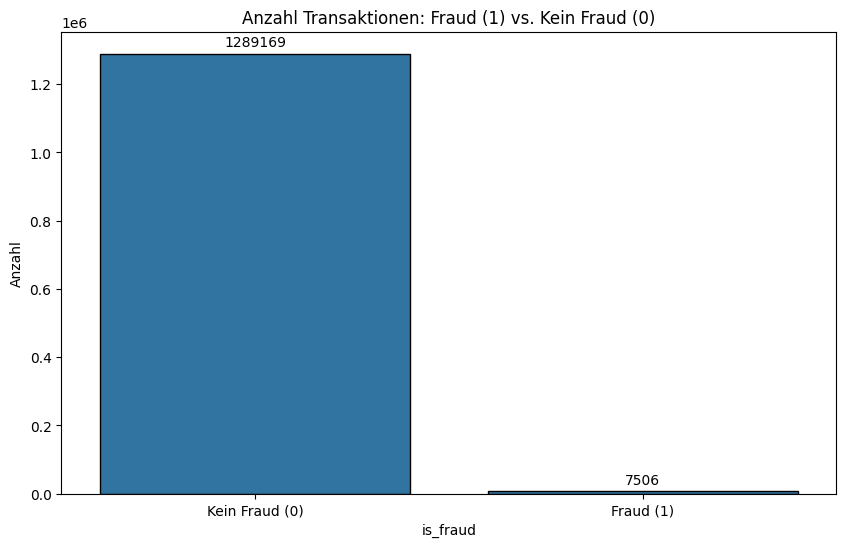

In [2]:
plt.figure()
ax = sns.countplot(x="is_fraud", data=ds, edgecolor="black")

plt.title("Anzahl Transaktionen: Fraud (1) vs. Kein Fraud (0)")
plt.xlabel("is_fraud")
plt.ylabel("Anzahl")
plt.xticks([0, 1], ["Kein Fraud (0)", "Fraud (1)"])

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

Unten sehen wir eine Auflistung, aller Kategorien mit der Anzahl Transaktionen.

In [3]:
# Kategorien-Auflistung der Anzahl Transaktionen
ds["category"].unique()
ds["category"].nunique()
ds["category"].value_counts()

category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64

### Geschlechtervergleich pro Kategorie

Wir haben für uns einige Annahmen getroffen, welches Geschlecht in welcher Kategorie mehr Transaktionen durchgeführt hat. Anschliessend wurde ein Barplot erstellt mit der Verteilung.

- misc_net: Keine Vermutung da dies die Daten von nicht zugeordneten online Transaktionen sind
- misc_pos: Keine Vermutung da dies die Daten von nicht zugeordneten physischen Transaktionen sind
- grocery_pos: Mehr Frauen haben diese Transaktionen durchgeführt
- grocery_net Mehr Frauen haben diese Transaktionen durchgeführt
- entertainment: Mehr Männer haben diese Transaktionen durchgeführt
- gas_transport: Mehr Männer haben diese Transaktionen durchgeführt
- shopping_net: Mehr Frauen haben diese Transaktionen durchgeführt
- shopping_pos: Mehr Frauen haben diese Transaktionen durchgeführt
- food_dining: Mehr Männer haben diese Transaktionen durchgeführt
- personal_care: Mehr Frauen haben diese Transaktionen durchgeführt
- health fitness: Wir denken hier sind beide Geschlechter gleich auf oder die Frauen leicht im mehr.
- travel: Mehr Männer haben diese Transaktionen durchgeführt
- kids_pets: Mehr Männer haben diese Transaktionen durchgeführt
- home: Mehr Männer haben diese Transaktionen durchgeführt

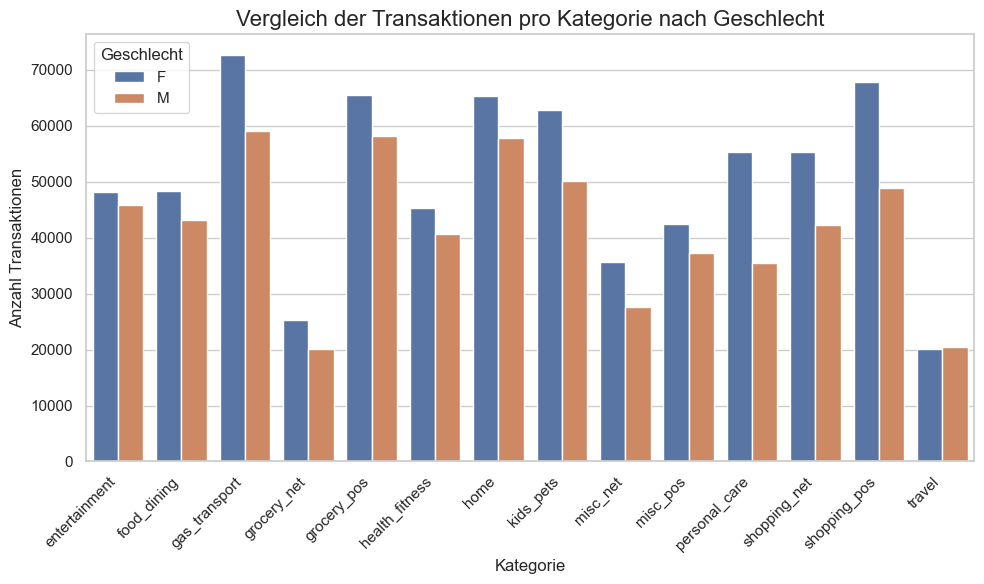

In [4]:
sns.set(style="whitegrid")

# Gruppieren nach Kategorie und Geschlecht und die Anzahl zählen
category_gender_counts = ds.groupby(['category', 'gender']).size().reset_index(name='count')

# Balkendiagramm erstellen
plt.figure()
sns.barplot(x='category', y='count', hue='gender', data=category_gender_counts)

# Diagramm anpassen
plt.title("Vergleich der Transaktionen pro Kategorie nach Geschlecht", fontsize=16)
plt.xlabel("Kategorie", fontsize=12)
plt.ylabel("Anzahl Transaktionen", fontsize=12)
plt.xticks(rotation=45, ha='right')  # x-Achsenbeschriftungen lesbar machen
plt.legend(title='Geschlecht')
plt.tight_layout()

### Evaluierung:

Wir sehen, dass in jeder Kategorie die Frau mehr Transaktionen durchführt als der Mann. Den einzigen kleinen Unterschied liegt bei der Kategorie travel wo der Mann leicht mehr Transaktionen macht als die Frau.


### Amount Spent

Wir Analysieren die allgemein ausgegebenen Beträge, die Verteilung der Beträge auf die Kategorien und wie die Ausgaben mit dem Geschlecht zusammenhängt. Zuerst wird alles ohne log dargestellt, danach mit dem log, damit es Übersichtlicher wird

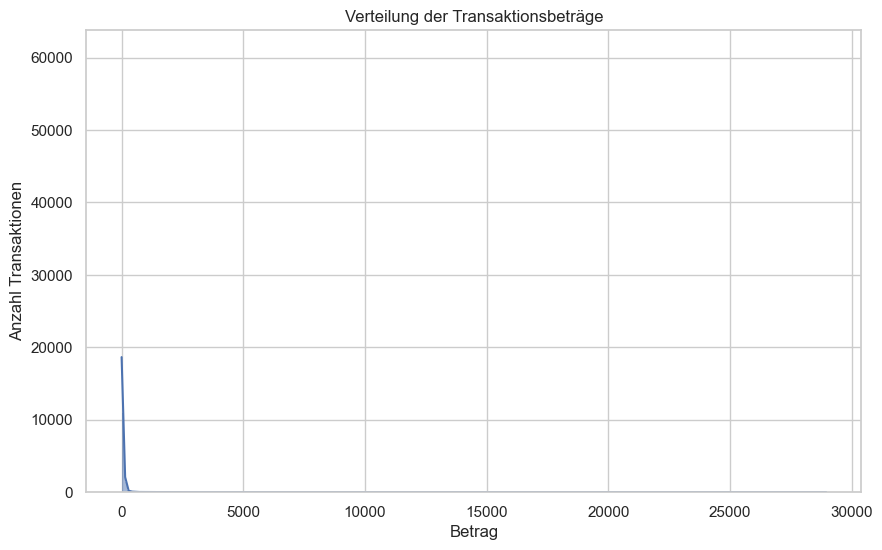

Anzahl Ausreisser: 67290
Z-Score Ausreisser: 12738
Median: 47.52
Mod. Z-Score-Ausreisser: 40359


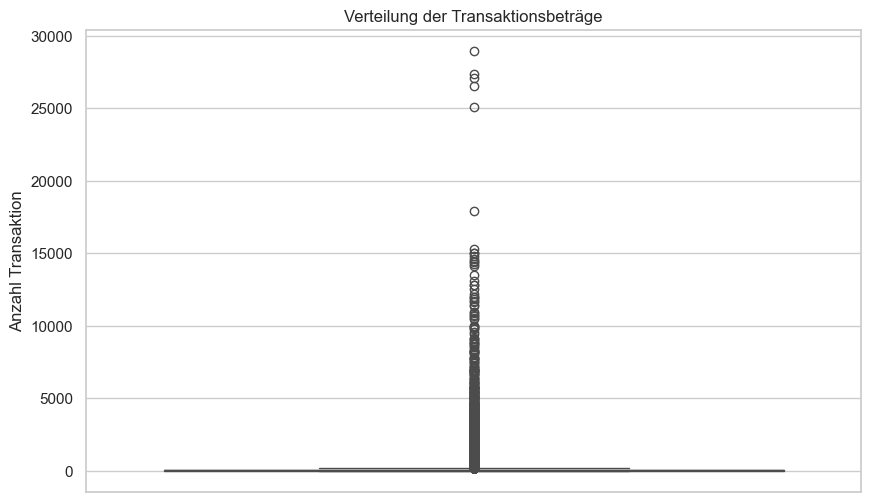

Median: 3.8819760840758493
Mod. Z-Score-Ausreisser: 400


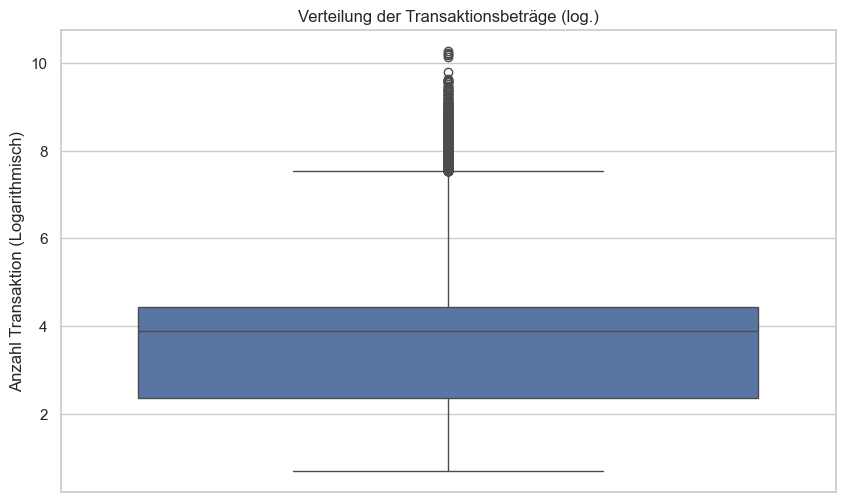

In [5]:
plt.figure()
sns.histplot(ds['amt'], bins='fd', kde=True)
plt.title("Verteilung der Transaktionsbeträge")
plt.xlabel("Betrag")
plt.ylabel("Anzahl Transaktionen")
plt.show()

# Tukey
Q1 = ds['amt'].quantile(0.25)
Q3 = ds['amt'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - 1.5*IQR
upper_fence = Q3 + 1.5*IQR
outliers = ds[(ds['amt'] < lower_fence) | (ds['amt'] > upper_fence)]
print(f"Anzahl Ausreisser: {len(outliers)}")

# Z-Score
ds['z_score'] = stats.zscore(ds['amt'])
outliers_z = ds[abs(ds['z_score']) > 3]
print(f"Z-Score Ausreisser: {len(outliers_z)}")

# Modifizierter Z-Score (robust gegen Schiefe)
median_amt = ds['amt'].median()
mad_amt = (ds['amt'] - median_amt).abs().median()
ds['mod_z'] = 0.6745 * (ds['amt'] - median_amt) / mad_amt
outliers_modz = ds[ds['mod_z'].abs() > 3.5]
print(f"Median: {median_amt}")
print(f"Mod. Z-Score-Ausreisser: {len(outliers_modz)}")


plt.figure()
sns.boxplot(ds['amt'])
plt.title("Verteilung der Transaktionsbeträge")
plt.ylabel("Anzahl Transaktion")
plt.show()


# LOGARITHMISCHE SKALA
log_amt = np.log1p(ds['amt'])

median_amt = log_amt.median()
mad_amt = (log_amt - median_amt).abs().median()
ds['mod_z'] = 0.6745 * (log_amt - median_amt) / mad_amt
outliers_modz = ds[ds['mod_z'].abs() > 3.5]
print(f"Median: {median_amt}")
print(f"Mod. Z-Score-Ausreisser: {len(outliers_modz)}")


plt.figure()
sns.boxplot(log_amt)
plt.title("Verteilung der Transaktionsbeträge (log.)")
plt.ylabel("Anzahl Transaktion (Logarithmisch)")
plt.show()

Text(0, 0.5, 'Dichte')

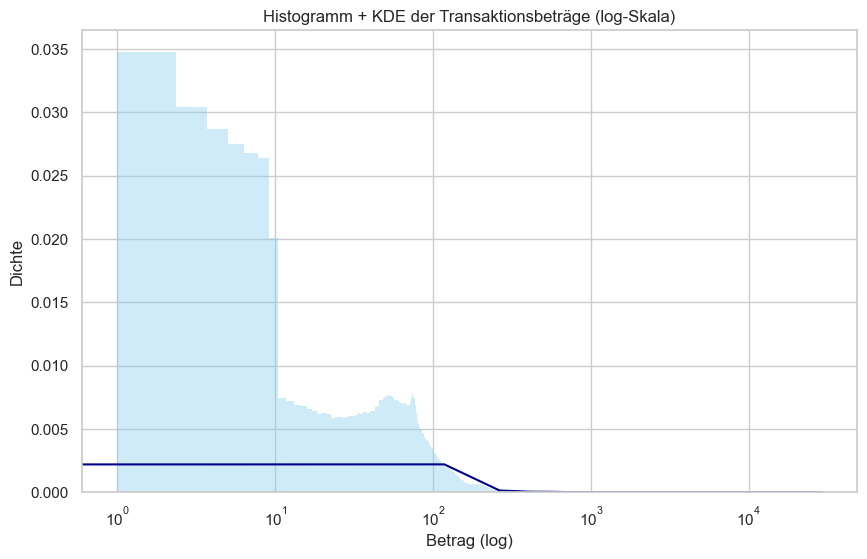

In [6]:
plt.figure()
sns.histplot(ds['amt'], bins='fd', stat='density', alpha=0.4, color='skyblue', edgecolor='black')
sns.kdeplot(ds['amt'], bw_adjust=1.0, color='darkblue')
plt.xscale('log')
plt.title("Histogramm + KDE der Transaktionsbeträge (log-Skala)")
plt.xlabel("Betrag (log)")
plt.ylabel("Dichte")


Bei dem Histogramm können wir nun besser sehen, wie die Beträge aufgeteilt sind und wir haben eine starke Rechtsschiefe, also es gibt eindeutig mehr kleinere Transaktionssummen. 


### KDE mit Bandbreiteneinfluss
Als nächsten haben wir verschiedene Bandbreiten ausporbiert und geplottet.
Die Bandbreite fungiert als Glättungsparameter der KDE. Eine sehr kleine Bandbreite (undersmoothing) macht lokales Rauschen in den Transaktionsdaten sichtbar, was zu einer Überinterpretation von Zufallsschwankungen führen kann. Eine sehr grosse Bandbreite (oversmoothing) hingegen glättet die Verteilung so stark, dass wichtige Details, wie zum Beispiel mehrere lokale Maxima (Multimodalität) bei bestimmten Betragsklassen, verloren gehen könnten. Der Vergleich hilft dabei, den optimalen Kompromiss zwischen Detailtreue und Generalisierung zu finden.

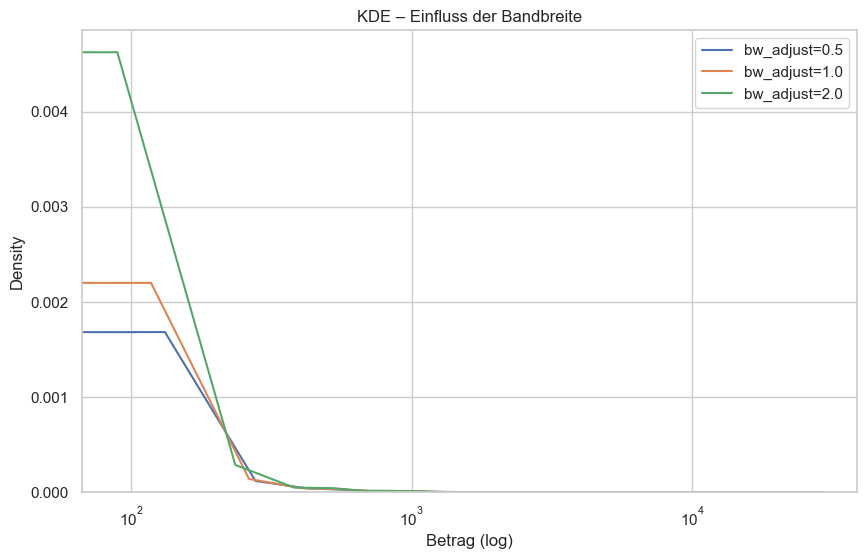

In [7]:
# Vergleich verschiedener Glättungsgrade (bw_adjust)
for bw in [0.5, 1.0, 2.0]:
    sns.kdeplot(ds['amt'], bw_adjust=bw, label=f'bw_adjust={bw}')
plt.xscale('log')
plt.title("KDE – Einfluss der Bandbreite")
plt.xlabel("Betrag (log)")
plt.legend()

### QQ-Plot 

Während ein Standard-Q-Q-Plot mit einer 45°-Referenzlinie aufgrund der unterschiedlichen Skalierung von Theorie und Empirie schwer interpretierbar ist, erlaubt die Verwendung einer standardisierten Referenzlinie (`line='s'`) eine präzisere Analyse der Verteilungsform. 

In beiden Fällen zeigt sich eine deutliche Abweichung der Datenpunkte von der Geraden an den Rändern (den sogenannten "Tails"). Diese ausgeprägte Krümmung bestätigt die **Heavy-Tail-Charakteristik** der Transaktionsbeträge: Extremwerte treten wesentlich häufiger auf, als es bei einer Normalverteilung zu erwarten wäre.

Text(0.5, 1.0, 'QQ-Plot der Transaktionsbeträge')

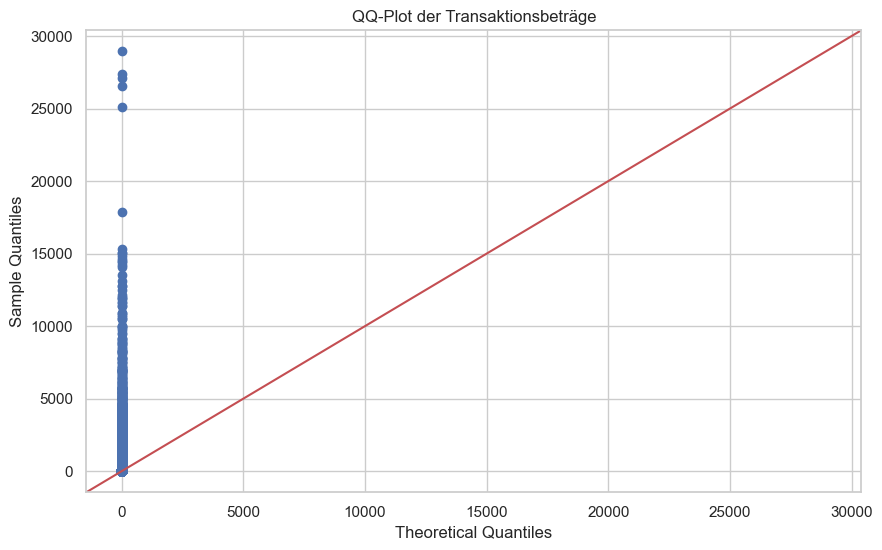

In [8]:
sm.qqplot(ds['amt'], line='45')
plt.title("QQ-Plot der Transaktionsbeträge")

Text(0.5, 1.0, 'QQ-Plot der Transaktionsbeträge')

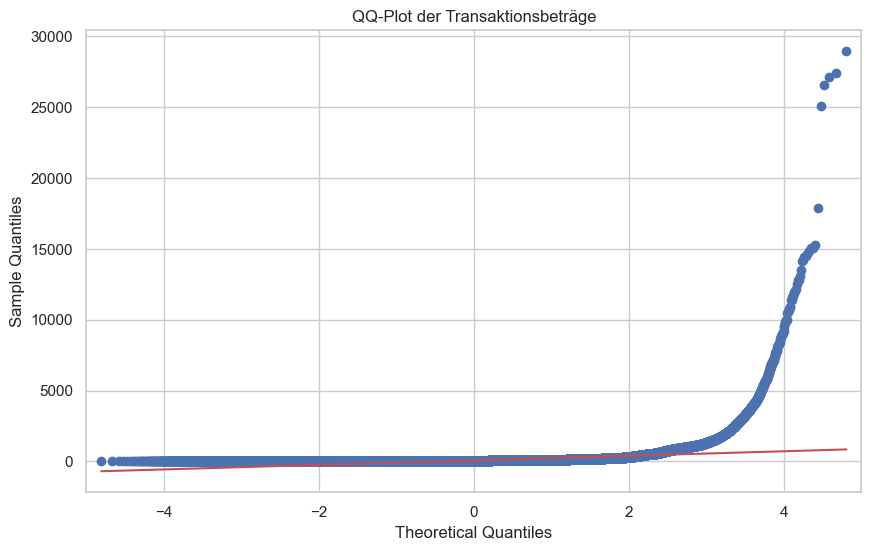

In [9]:
sm.qqplot(ds['amt'], line='s')
plt.title("QQ-Plot der Transaktionsbeträge")

### ECDF Plot

Text(0, 0.5, 'Kumulative Wahrscheinlichkeit')

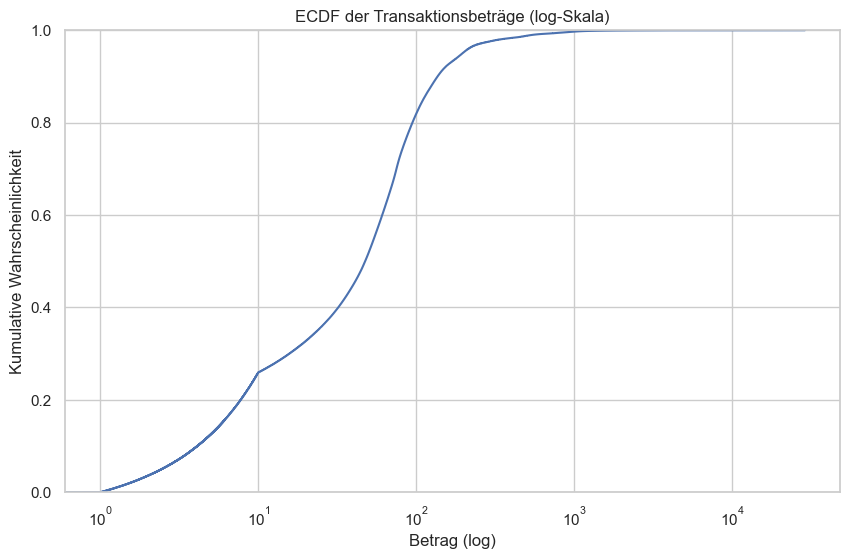

In [10]:
plt.figure()
sns.ecdfplot(data=ds, x='amt')
plt.xscale('log')
plt.title("ECDF der Transaktionsbeträge (log-Skala)")
plt.xlabel("Betrag (log)")
plt.ylabel("Kumulative Wahrscheinlichkeit")

### Boxplot mit Stripplot

Wir haben eine Boxplot erstellt um Pro Kategorie die Ausreisser zu finden und um diese moch ein bischen genauer darzustellen, haben wir in den Boxplot einen Stripplot gemacht um die Verteilung besser zu sehen. Auch hier wurde zuerst der normale Boxplot erstellt und dann wieder der Logarithmische für bessere visualität

Text(0, 0.5, 'Betrag (Logarithmisch)')

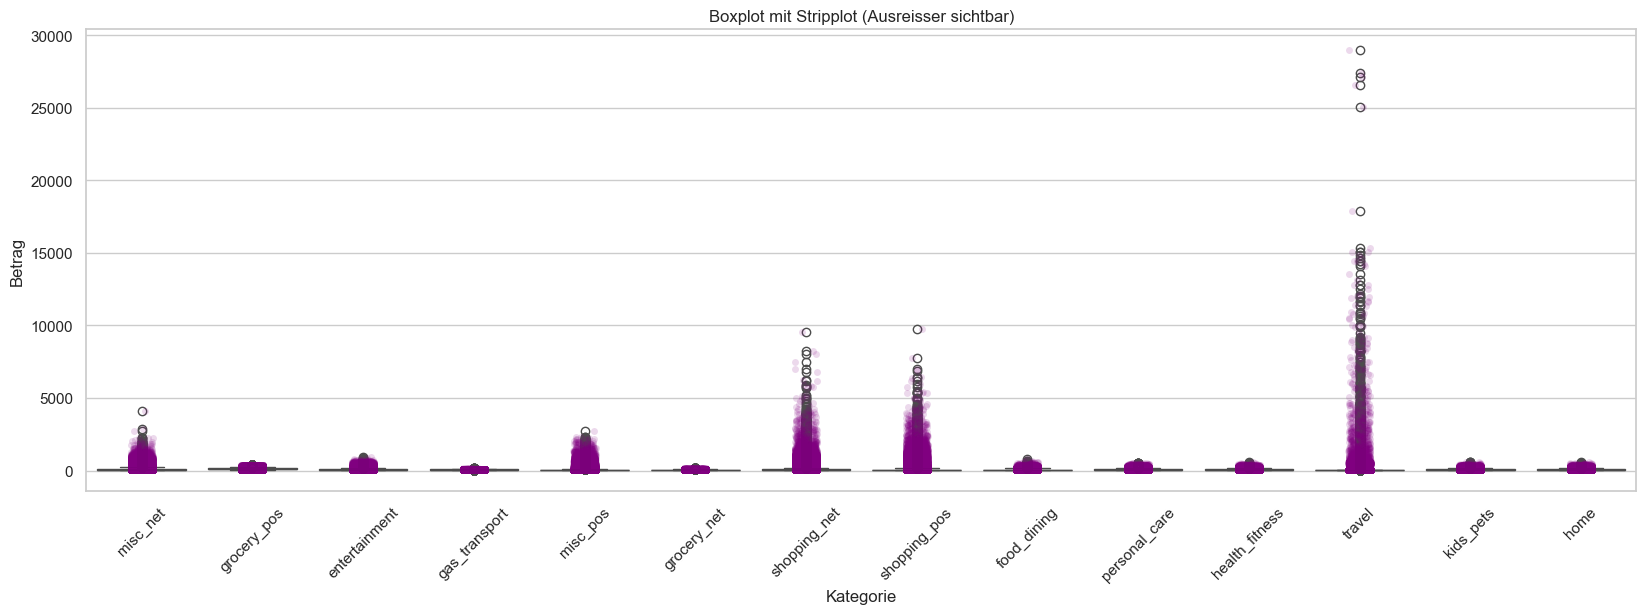

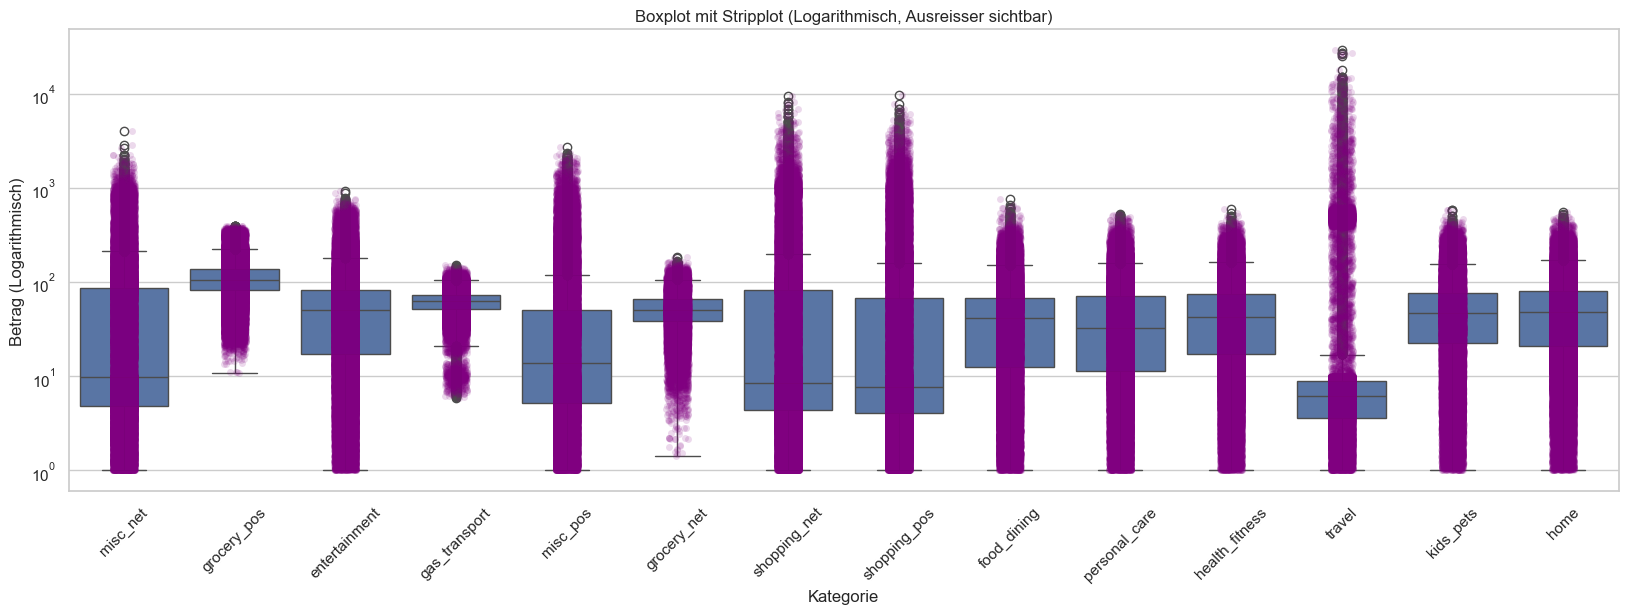

In [11]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=ds, x='category', y='amt')
sns.stripplot(data=ds, x='category', y='amt', color='purple', alpha=0.15, jitter=True)
plt.xticks(rotation=45)
plt.title("Boxplot mit Stripplot (Ausreisser sichtbar)")
plt.xlabel("Kategorie")
plt.ylabel("Betrag")

plt.figure(figsize=(20, 6))
sns.boxplot(data=ds, x='category', y='amt')
sns.stripplot(data=ds, x='category', y='amt', color='purple', alpha=0.15, jitter=True)
plt.xticks(rotation=45)
plt.title("Boxplot mit Stripplot (Logarithmisch, Ausreisser sichtbar)")
plt.xlabel("Kategorie")
plt.yscale("log")
plt.ylabel("Betrag (Logarithmisch)")

## Transaktionsbeträge nach Geschlecht

### Barplot
Wir haben nun einen Barplot erstellt, um zu zeigen wie die Durchschnittsausgaben pro Geschlecht auf die Kategorien verteilt sind, und wir sehen im Vergleich zu Anzahl Transaktionenm, dass es hier nicht mehr gleich Einseitig ist. Also Männer haben auch in gewissen Kategorien höhere Ausgaben wie zb in travel, home usw.

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_62480/1273720670.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ds, x='category', y='amt', hue='gender',  palette='coolwarm', ci=None)


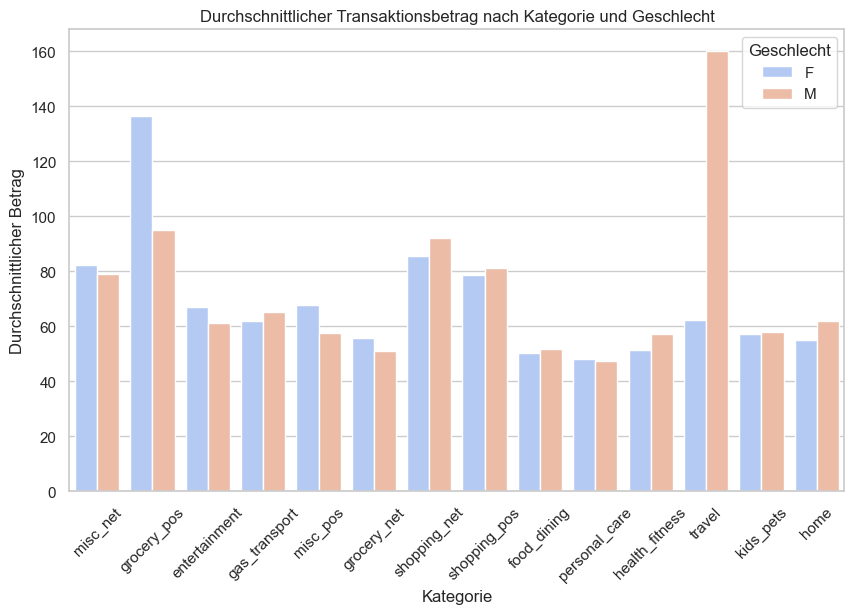

In [12]:
# Durchschnittlicher Betrag pro Kategorie und Geschlecht
plt.figure()
sns.barplot(data=ds, x='category', y='amt', hue='gender',  palette='coolwarm', ci=None)
plt.xticks(rotation=45)
plt.title("Durchschnittlicher Transaktionsbetrag nach Kategorie und Geschlecht")
plt.ylabel("Durchschnittlicher Betrag")
plt.xlabel("Kategorie")
plt.legend(title="Geschlecht")

#### ECDF zu Transaktionsbeträgen dem Geschlecht



Text(0, 0.5, 'Kumulative Wahrscheinlichkeit')

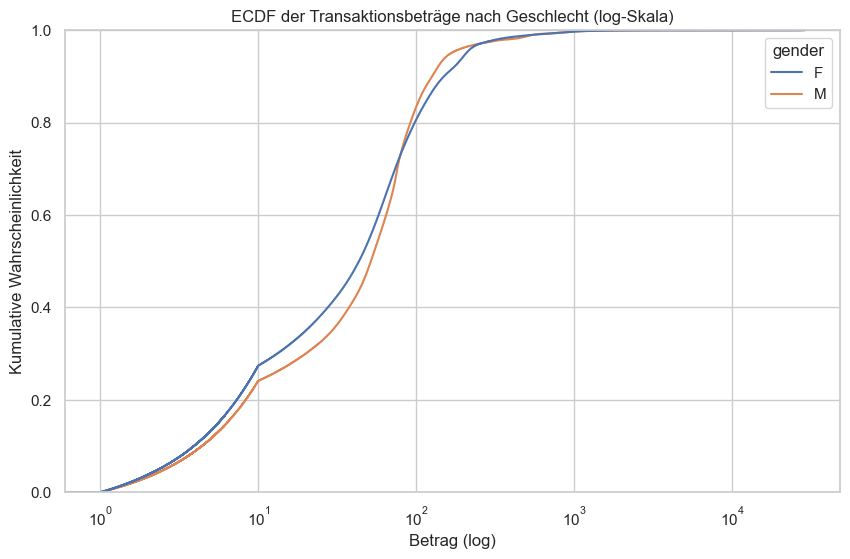

In [13]:
# ECDF nach Geschlecht
plt.figure()
sns.ecdfplot(data=ds, x='amt', hue='gender')
plt.xscale('log')
plt.title("ECDF der Transaktionsbeträge nach Geschlecht (log-Skala)")
plt.xlabel("Betrag (log)")
plt.ylabel("Kumulative Wahrscheinlichkeit")

Die Verteilungen sind sich sehr ähnlich, aber Männer haben einen leicht höheren Anteil an mittelgroßen bis großen Transaktionen im Vergleich zu Frauen, bevor sich die Kurven bei den sehr hohen Beträgen (>10 
3) wieder angleichen

### Boxplot zu Beträgen nach Geschlecht



/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_62480/3990455400.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ds, x='gender', y='amt', palette='pastel')


Text(0, 0.5, 'Betrag')

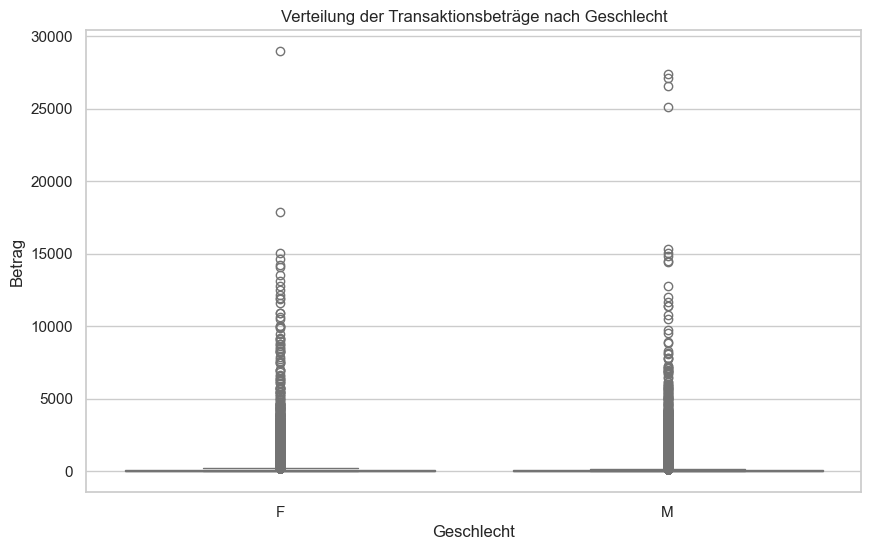

In [14]:
# Boxplot der Beträge nach Geschlecht
plt.figure()
sns.boxplot(data=ds, x='gender', y='amt', palette='pastel')
plt.title("Verteilung der Transaktionsbeträge nach Geschlecht")
plt.xlabel("Geschlecht")
plt.ylabel("Betrag")

Wie sehen einige Ausreisser wobei man bei den Männern mehr hohe Ausreisser sieht als bei den Frauen und bei den Frauen dafür den Höchsten.

### Violinplot zu den Transaktionbeträgen pro Geschlecht

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_62480/44646706.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=ds, x='gender', y='amt', inner='quartile', cut=0, bw_adjust=1.0, palette='coolwarm')
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_62480/44646706.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


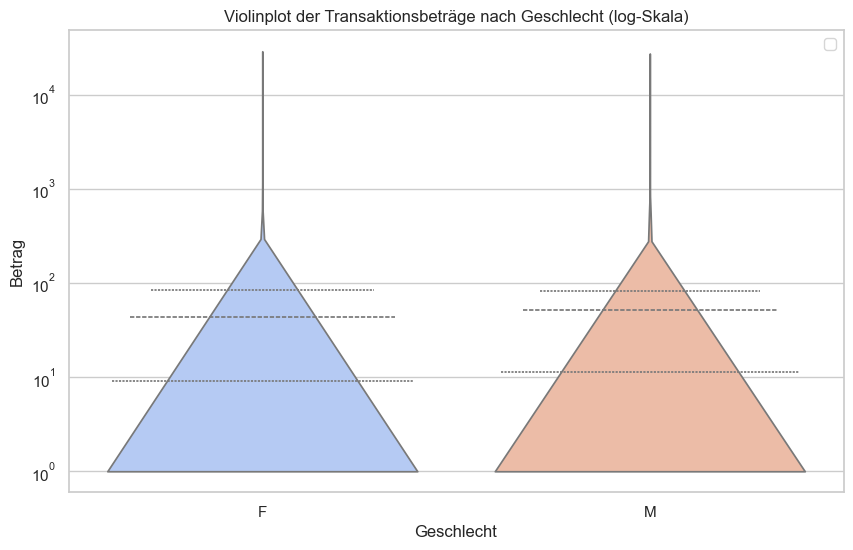

In [15]:
plt.figure()
sns.violinplot(data=ds, x='gender', y='amt', inner='quartile', cut=0, bw_adjust=1.0, palette='coolwarm')
plt.yscale('log')
plt.title("Violinplot der Transaktionsbeträge nach Geschlecht (log-Skala)")
plt.xlabel("Geschlecht")
plt.ylabel("Betrag")
plt.legend()

Wie sehen eine Pyramiden Form, was darauf hinweist, dass wir keine Normalverteilung haben sondern viele kleine Beträge und auch hier sehen wir, dass Männer einen ganz leicht höheren Schnitt aufweist.

### Boxplot + Stripplot nach Geschlecht

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_62480/4191077864.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ds, x='gender', y='amt', whis=1.5, showfliers=False, palette='pastel')


Text(0, 0.5, 'Betrag')

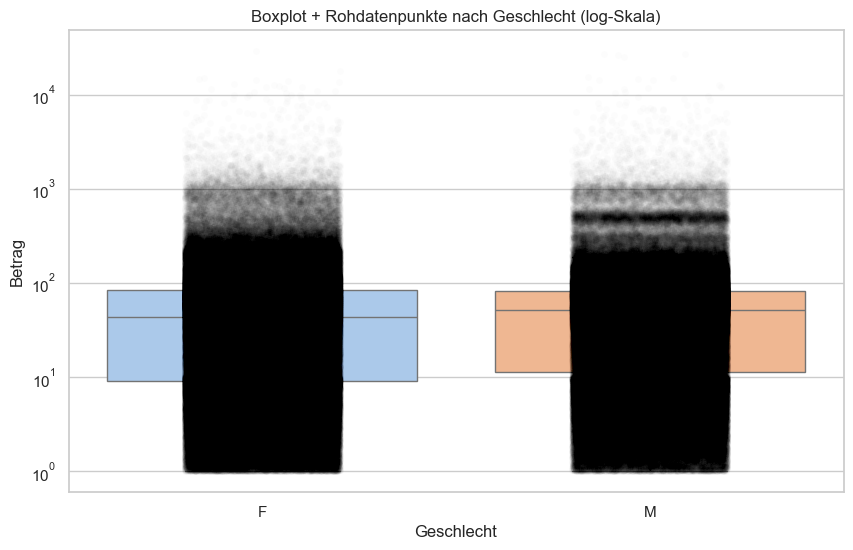

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(data=ds, x='gender', y='amt', whis=1.5, showfliers=False, palette='pastel')
sns.stripplot(data=ds, x='gender', y='amt', color='black', alpha=0.01, jitter=0.2)
plt.yscale('log')
plt.title("Boxplot + Rohdatenpunkte nach Geschlecht (log-Skala)")
plt.xlabel("Geschlecht")
plt.ylabel("Betrag")

Die Grafik verdeutlicht die Verteilung der Transaktionsbeträge: Während beide Geschlechter viele kleine Beträge aufweisen, ist bei den Männern eine höhere Varianz im oberen Preissegment erkennbar. Besonders auffällig sind die dunkleren horizontalen Verdichtungen in der Punktwolke der Männer, die zeigen, dass bestimmte höhere Beträge häufiger angesteuert werden als bei den Frauen.

In [17]:
plt.figure(figsize=(10,6))
sns.swarmplot(data=ds, x='gender', y='amt')
plt.yscale('log')
plt.title("Boxplot + Rohdatenpunkte nach Geschlecht (log-Skala)")
plt.xlabel("Geschlecht")
plt.ylabel("Betrag")

KeyboardInterrupt: 

: 

: 

### Histplot zu den Transaktionen nach Geschlecht

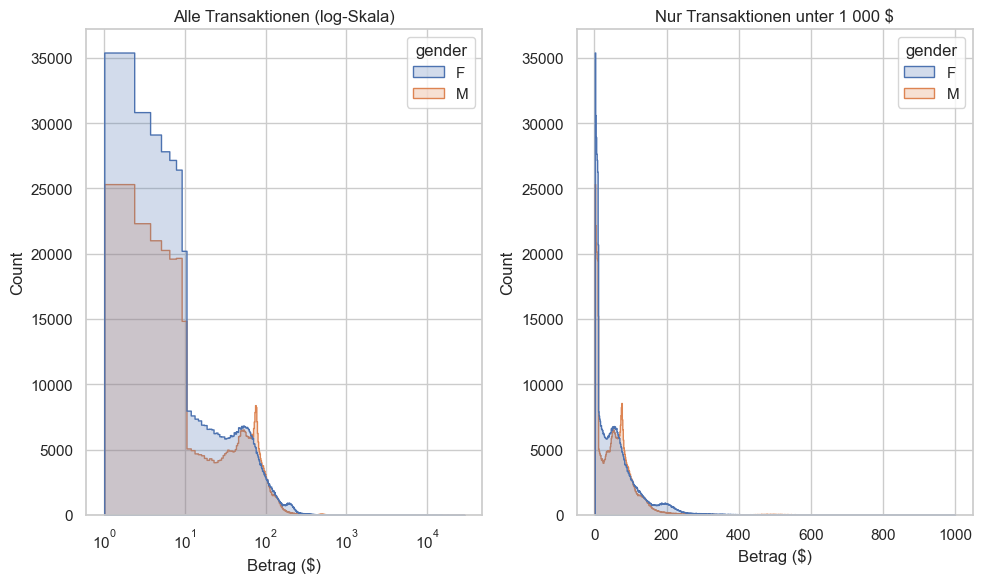

In [ ]:
fig, axes = plt.subplots(1, 2)

sns.histplot(data=ds, x='amt', hue='gender', bins='fd', element='step', ax=axes[0])
axes[0].set_title("Alle Transaktionen (log-Skala)")
axes[0].set_xlabel("Betrag ($)")
axes[0].set_xscale('log')

sns.histplot(data=ds[ds['amt'] < 1000], x='amt', hue='gender', bins='fd', element='step', ax=axes[1])
axes[1].set_title("Nur Transaktionen unter 1 000 $")
axes[1].set_xlabel("Betrag ($)")

plt.tight_layout()

Diese Histogramme bestätigen und verdeutlichen das bisher beobachtete Kaufverhalten noch einmal auf einer quantitativen Ebene. Während die log-Skala im linken Diagramm das enorme Volumen an Kleinsttransaktionen bei beiden Geschlechtern unterstreicht, zeigt die lineare Darstellung (rechts) die Details im Bereich bis 1.000$ . Besonders markant ist hier der scharfe Peak bei den Männern im Bereich zwischen 50$ und 100$, der die bereits im Boxplot sichtbaren 'Häufungen' erklärt. Insgesamt wird deutlich, dass Frauen zwar eine höhere Gesamtzahl an Transaktionen aufweisen (höhere blaue Fläche), das Ausgabeverhalten der Männer jedoch durch spezifische Schwerpunkte bei moderaten Beträgen geprägt ist.